##### Import the libraries

In [1]:
import os
import json
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as transforms
from torchvision.ops import box_iou
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.metrics import precision_recall_fscore_support
import rich
from ultralytics import YOLO

#### load yolo

In [2]:
# Load the custom-trained weights
model = YOLO('FacadeDetection/YOLOv8_training11/weights/best.pt')

##### calculate the predicted area (temporarly for the training dataset until using the evaluating dataset)

In [9]:
file_name = "00001.jpg"

image_path = os.path.join("datasets", "train", "images", file_name)

# Run prediction
results = model.predict(source=image_path, conf=0.1, save=False, save_txt=False, show=False)

# Extract predictions from the output
boxes = []
scores = []

for result in results:
    for box, score in zip(result.boxes.xyxy, result.boxes.conf):
        boxes.append(box.cpu().numpy())
        scores.append(score.item())

# Convert to tensors for consistency
boxes = torch.tensor(boxes)
scores = torch.tensor(scores)

# Filter boxes by scores > 0.1
threshold = 0.1
valid_boxes = boxes[scores > threshold]

# Get the count of valid boxes
num_valid_boxes = valid_boxes.shape[0]

# Calculate the area of each valid bounding box
areas = (valid_boxes[:, 2] - valid_boxes[:, 0]) * (valid_boxes[:, 3] - valid_boxes[:, 1])

# Sum the areas to get windows_area
windows_area_p = areas.sum().item()

# Print the total windows area
rich.print(f"Number of valid boxes: {num_valid_boxes}")
rich.print(f"Total predicted windows area for '{file_name}': {windows_area_p} pixels²")


image 1/1 c:\Users\mohamad\WWR\datasets\train\images\00001.jpg: 640x416 6 windows, 56.2ms
Speed: 4.6ms preprocess, 56.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 416)


Number of valid boxes: 6

Total predicted windows area for '00001.jpg': 75001.578125 pixels²

##### ground truth area

In [4]:
file_name_test = "rectified_facade_DENW11AL0000h3Gt.jpg"

# Load the JSON file
file_path = os.path.join("Evaluation_subset", "labels_facade_dataset_2024-06-09-08-43-50.json")
with open(file_path, 'r') as f:
    data = json.load(f)

image_id = next(item["id"] for item in data["images"] if item["file_name"] == file_name_test)

# Step 2: Filter annotations for the image_id and category "window" (category_id = 1)
window_annotations = [
    annotation for annotation in data["annotations"]
    if annotation["image_id"] == image_id and annotation["category_id"] == 1
]

# Step 3: Calculate total area and count
windows_area_gt = sum(ann["area"] for ann in window_annotations)
num_windows = len(window_annotations)

# rich.print(f"Number of windows: {num_windows}")
rich.print(f"Total window area for '{file_name_test}': {windows_area_gt} pixels²")


Total window area for 'rectified_facade_DENW11AL0000h3Gt.jpg': 21784.693692249522 pixels²

##### image area

In [5]:
# Step 1: Find the image details for the given file name
image_details = next(item for item in data["images"] if item["file_name"] == file_name_test)

# Extract width and height
image_width = image_details["width"]
image_height = image_details["height"]

# Calculate the image area
image_area = image_width * image_height

# rich.print(f"Image dimensions for '{file_name}': {image_width}x{image_height}")
rich.print(f"Total image area for '{file_name}': {image_area} pixels²")

Total image area for '00001.jpg': 91664 pixels²

##### WWR

In [6]:
# Calculate ground truth WWR
wwr_gt = windows_area_gt / image_area if image_area > 0 else 0

rich.print(f"Window-to-Wall Ratio (ground truth) (WWR) for '{file_name_test}': {wwr_gt:.4f}")

# Calculate predicted WWR
wwr_P = windows_area_p / image_area if image_area > 0 else 0

rich.print(f"Window-to-Wall Ratio (predcited) (WWR) for '{file_name}': {wwr_P:.4f}")

# Calculate the absolute difference
wwr_difference = abs(wwr_gt - wwr_P)

# Optionally, calculate percentage difference
wwr_percentage_diff = (wwr_difference / wwr_gt * 100) if wwr_gt > 0 else 0

# Print the results
# rich.print(f"[bold]Difference between ground truth and predicted WWR:[/bold] {wwr_difference:.4f}")
rich.print(f"[bold]Percentage difference:[/bold] {wwr_percentage_diff:.2f}%")

Window-to-Wall Ratio (ground truth) (WWR) for 'rectified_facade_DENW11AL0000h3Gt.jpg': 0.2377

Window-to-Wall Ratio (predcited) (WWR) for '00001.jpg': 0.8182

Percentage difference: 244.29%

##### Visualizing the results (yolo) on the Evalution subset


image 1/1 c:\Users\mohamad\WWR\datasets\train\images\00001.jpg: 640x416 6 windows, 54.3ms
Speed: 12.2ms preprocess, 54.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 416)


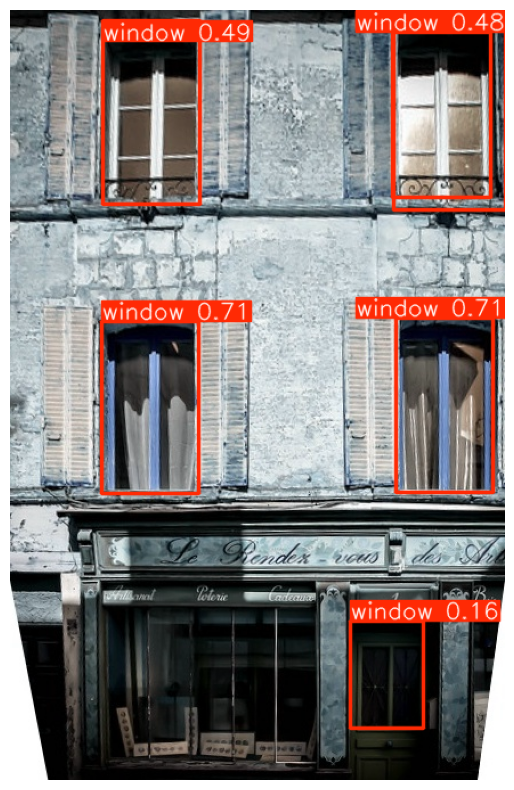

In [8]:
# Define the image path
# image_path = os.path.join("Evaluation_subset", "rectified_facade_DENW11AL0000h3Gt.jpg")
image_path = os.path.join("datasets", "train", "images", "00001.jpg")
# image_path = os.path.join("Evaluation_subset", "rectified_facade_DENW11AL0000h3Ho.jpg")

# Load the YOLO model
model = YOLO('FacadeDetection/YOLOv8_training11/weights/best.pt')  # Load a pretrained YOLOv8 model

# Run prediction
results = model.predict(source=image_path, conf=0.1, save=False, save_txt=False, show=False)

# print("results", results)

# Load and visualize the image with predictions
annotated_image = results[0].plot()  # Plot the results on the image

# Display the image using Matplotlibs
plt.figure(figsize=(10, 10))
plt.imshow(annotated_image)
plt.axis("off")
plt.show()
